In [3]:
import cv2
from doclayout_yolo import YOLOv10

# Load the pre-trained model
model = YOLOv10("../models/doclayout_yolo_docstructbench_imgsz1024.pt")

# Perform prediction
det_res = model.predict(
    "../data/bib22651590_19000519_153665_0_0004_2449x3150.jpg",   # Image to predict
    imgsz=1024,        # Prediction image size
    conf=0.2,          # Confidence threshold
    device="cpu"    # Device to use (e.g., 'cuda:0' or 'cpu')
)

# Annotate and save the result
annotated_frame = det_res[0].plot(pil=True, line_width=5, font_size=20)
cv2.imwrite("result.jpg", annotated_frame)


image 1/1 /Users/jonathanjayes/Documents/PhD/newspapers-1/notebooks/../data/bib22651590_19000519_153665_0_0004_2449x3150.jpg: 1024x800 78 titles, 129 plain texts, 1 abandon, 10 figures, 1 figure_caption, 6 tables, 2 table_captions, 887.3ms
Speed: 12.0ms preprocess, 887.3ms inference, 1.5ms postprocess per image at shape (1, 3, 1024, 800)


True

In [ ]:
det_res

# save as a pickle file

import pickle

with open("result.pkl", "wb") as f:
    pickle.dump(det_res, f)


In [16]:
det_res[0].orig_shape

(3150, 2449)

In [37]:
import pandas as pd
from pathlib import Path

# Process the single detection result
try:
    # Get the image path from the detection result
    image_path = Path("../data/bib22651590_19000519_153665_0_0004_2449x3150.jpg")
    filename = image_path.name

    # Get image dimensions from the result - accessing the first element
    img_height, img_width = det_res[0].orig_shape  # Original image height and width
    
    # Prepare to collect detections
    all_detections = []
    
    # Extract bounding box information - from the first element
    for box in det_res[0].boxes:
        x1, y1, x2, y2 = box.xyxy[0].tolist()
        conf = box.conf[0].item()
        cls = box.cls[0].item()
        cls_name = det_res[0].names[int(cls)]

        detection_info = {
            "filename": filename,
            "class": cls_name,
            "confidence": conf,
            "x1": x1,
            "y1": y1,
            "x2": x2,
            "y2": y2,
            "page_height": img_height,
            "page_width": img_width,
        }
        all_detections.append(detection_info)
    
    # Create output filenames based on input filename
    base_filename = image_path.stem
    output_parquet = f"../results/{base_filename}_detected.parquet"
    output_json = f"../results/{base_filename}_detected.json"
    
    # Create results directory if it doesn't exist
    Path("../results").mkdir(exist_ok=True, parents=True)
    
    # Save detection results to Parquet and JSON
    df = pd.DataFrame(all_detections)
    df.to_parquet(output_parquet, index=False)
    df.to_json(output_json, orient="records", indent=2)
    
    print(f"Results saved to {output_parquet} and {output_json}")
    print(f"Detected {len(all_detections)} objects")
    
    # Display a sample of the data
    if len(df) > 0:
        print("\nSample of detected objects:")
        print(df.head(3))
    
except Exception as e:
    import traceback
    print(f"Error processing detection result: {str(e)}")
    print(traceback.format_exc())

Results saved to ../results/bib22651590_19000519_153665_0_0004_2449x3150_detected.parquet and ../results/bib22651590_19000519_153665_0_0004_2449x3150_detected.json
Detected 227 objects

Sample of detected objects:
                                           filename       class  confidence  \
0  bib22651590_19000519_153665_0_0004_2449x3150.jpg  plain text    0.888379   
1  bib22651590_19000519_153665_0_0004_2449x3150.jpg  plain text    0.886986   
2  bib22651590_19000519_153665_0_0004_2449x3150.jpg       title    0.870746   

            x1           y1           x2           y2  page_height  page_width  
0   224.727158   845.785522   788.750183   902.748779         3150        2449  
1   199.385681  1314.649536   816.381592  1492.033936         3150        2449  
2  1502.569824  1274.670776  1688.805908  1297.646240         3150        2449  


In [38]:
import pandas as pd
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches  # Fixed import
from typing import List, Dict, Tuple, Any, Optional
import os
import json
from sklearn.cluster import DBSCAN

def convert_json_to_dataframe(json_data: List[Dict]) -> pd.DataFrame:
    """
    Convert the doclayout-yolo JSON output to a pandas DataFrame.
    """
    # Create DataFrame from JSON
    df = pd.DataFrame(json_data)
    
    # Standardize coordinate column names to match the bbox_functions module
    df = df.rename(columns={
        'x1': 'x1', 
        'y1': 'y1', 
        'x2': 'x2', 
        'y2': 'y2'
    })
    
    # Add page_id column (required by bbox_functions)
    df['page_id'] = df['filename'].iloc[0] if 'filename' in df.columns else "page_1"
    
    # Add 'class' column if using different terminology
    if 'class' not in df.columns:
        df['class'] = df['class']
    
    return df

def filter_low_confidence_detections(df: pd.DataFrame, threshold: float = 0.5) -> pd.DataFrame:
    """
    Filter out detections with confidence below the specified threshold.
    """
    return df[df['confidence'] >= threshold].copy()

def add_derived_coordinates(df: pd.DataFrame) -> pd.DataFrame:
    """
    Add derived coordinates like center_x, center_y, width, height.
    """
    df = df.copy()
    df['width'] = df['x2'] - df['x1']
    df['height'] = df['y2'] - df['y1']
    df['center_x'] = df['x1'] + (df['width'] / 2)
    df['center_y'] = df['y1'] + (df['height'] / 2)
    df['area'] = df['width'] * df['height']
    return df

def detect_columns(df: pd.DataFrame) -> pd.DataFrame:
    """
    Detect columns in the newspaper by clustering x-coordinates.
    """
    from sklearn.cluster import DBSCAN
    
    # Get page width from the data
    page_width = df['page_width'].iloc[0]
    
    # Extract center x-coordinates of all boxes
    x_centers = df['center_x'].values.reshape(-1, 1)
    
    # Use DBSCAN for clustering
    clustering = DBSCAN(eps=page_width*0.08, min_samples=3).fit(x_centers)
    
    # Assign column numbers
    df['column_number'] = clustering.labels_
    
    # Handle noise points (assign to nearest cluster)
    if -1 in df['column_number'].values:
        # For noise points, find nearest cluster
        noise_points = df[df['column_number'] == -1]
        valid_clusters = df[df['column_number'] != -1].groupby('column_number')['center_x'].mean()
        
        for idx in noise_points.index:
            point_x = df.loc[idx, 'center_x']
            distances = abs(valid_clusters - point_x)
            nearest_cluster = distances.idxmin() if not distances.empty else 0
            df.loc[idx, 'column_number'] = nearest_cluster
    
    # Sort columns from left to right
    col_centers = df.groupby('column_number')['center_x'].mean().sort_values()
    col_mapping = {old_col: new_col for new_col, old_col in enumerate(col_centers.index)}
    df['column_number'] = df['column_number'].map(col_mapping)
    
    return df

def identify_content_blocks(df: pd.DataFrame) -> pd.DataFrame:
    """
    Group boxes into logical content blocks (articles, advertisements, etc.)
    Takes advantage of the fact that articles typically start with titles.
    """
    df = df.copy()
    df['block_id'] = -1  # Initialize block IDs
    
    # Sort by column and then y-coordinate
    df = df.sort_values(['column_number', 'y1'])
    
    # Find title boxes as they often indicate the start of a new content block
    title_boxes = df[df['class'] == 'title'].sort_values(['column_number', 'y1'])
    
    current_block = 0
    
    # Assign each title box as the start of a new block
    for idx, title_row in title_boxes.iterrows():
        df.loc[idx, 'block_id'] = current_block
        
        # Find all boxes below this title in the same column
        same_column = df['column_number'] == title_row['column_number']
        below_title = df['y1'] > title_row['y2']
        
        # Find the next title in the same column (if any)
        next_title = title_boxes[
            (title_boxes['column_number'] == title_row['column_number']) & 
            (title_boxes['y1'] > title_row['y2'])
        ]
        
        if not next_title.empty:
            next_title_y = next_title.iloc[0]['y1']
            before_next_title = df['y1'] < next_title_y
            block_boxes = df[same_column & below_title & before_next_title]
        else:
            # If no next title, include all boxes below in the same column
            block_boxes = df[same_column & below_title]
        
        # Assign block ID to these boxes
        df.loc[block_boxes.index, 'block_id'] = current_block
        
        current_block += 1
    
    # Handle any boxes not assigned to a block (typically those before the first title)
    for col in df['column_number'].unique():
        # Get boxes in this column that aren't assigned to a block
        unassigned = df[(df['column_number'] == col) & (df['block_id'] == -1)]
        
        if not unassigned.empty:
            # Create a new block for these
            df.loc[unassigned.index, 'block_id'] = current_block
            current_block += 1
    
    return df

def compute_reading_order(df: pd.DataFrame) -> pd.DataFrame:
    """
    Establish reading order for boxes within each block and across blocks.
    """
    df = df.copy()
    
    # Sort blocks by column and vertical position
    block_order = (
        df.groupby('block_id')
        .agg({'column_number': 'first', 'y1': 'min'})
        .sort_values(['column_number', 'y1'])
        .index.tolist()
    )
    
    block_rank = {block_id: i for i, block_id in enumerate(block_order)}
    
    # Assign global reading order
    reading_order = 0
    df['reading_order'] = -1
    
    for block_id in block_order:
        # Get boxes in this block
        block_boxes = df[df['block_id'] == block_id].sort_values(['y1'])
        
        # Assign reading order
        for idx in block_boxes.index:
            df.loc[idx, 'reading_order'] = reading_order
            reading_order += 1
    
    return df

def extract_image_patches(image_path: str, df: pd.DataFrame, padding: int = 10) -> List[Dict[str, Any]]:
    """
    Extract image patches based on content blocks with padding.
    """
    # Read the image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Could not read image at {image_path}")
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_height, image_width = image.shape[:2]
    
    patches = []
    
    # Group by block_id
    for block_id, block_df in df.groupby('block_id'):
        # Find bounding box that contains all elements in the block
        x1 = max(0, block_df['x1'].min() - padding)
        y1 = max(0, block_df['y1'].min() - padding)
        x2 = min(image_width, block_df['x2'].max() + padding)
        y2 = min(image_height, block_df['y2'].max() + padding)
        
        # Skip invalid boxes
        if x2 <= x1 or y2 <= y1:
            continue
        
        # Extract the patch
        patch = image[int(y1):int(y2), int(x1):int(x2)]
        
        # Determine content type
        if 'table' in block_df['class'].values:
            content_type = 'table'
        elif 'figure' in block_df['class'].values:
            content_type = 'figure'
        elif 'title' in block_df['class'].values:
            content_type = 'article'
        else:
            content_type = 'text'
        
        # Get the classes present in this block
        classes_present = block_df['class'].unique().tolist()
        
        patches.append({
            'image': patch,
            'coordinates': (int(x1), int(y1), int(x2), int(y2)),
            'content_type': content_type,
            'classes': classes_present,
            'block_id': block_id,
            'reading_order': block_df['reading_order'].min()
        })
    
    # Sort patches by reading order
    patches.sort(key=lambda x: x['reading_order'])
    
    return patches

def visualize_patches(image_path: str, patches: List[Dict[str, Any]], figsize: Tuple[int, int] = (15, 15)) -> None:
    """
    Visualize the extracted patches on the original image.
    """
    import matplotlib.patches as mpatches  # Add this import
    
    # Read the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Create figure and axes
    fig, ax = plt.subplots(figsize=figsize)
    
    # Display the image
    ax.imshow(image)
    
    # Color mapping for different content types
    color_map = {
        'article': 'green',
        'table': 'blue',
        'figure': 'red',
        'text': 'yellow'
    }
    
    # Draw patches
    for i, patch in enumerate(patches):
        x1, y1, x2, y2 = patch['coordinates']
        content_type = patch['content_type']
        
        # Create rectangle - fixed this line
        rect = mpatches.Rectangle(
            (x1, y1), 
            x2 - x1, 
            y2 - y1, 
            linewidth=2, 
            edgecolor=color_map.get(content_type, 'orange'),
            facecolor='none',
            label=content_type
        )
        
        ax.add_patch(rect)
        
        # Add patch number for reference
        ax.text(
            x1, 
            y1 - 5, 
            f"#{i} ({content_type})", 
            color='white', 
            fontsize=10,
            bbox=dict(facecolor=color_map.get(content_type, 'orange'), alpha=0.7)
        )
    
    plt.title("Extracted Patches")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def save_patches_as_images(patches: List[Dict[str, Any]], output_dir: str) -> List[str]:
    """
    Save extracted patches as individual image files.
    Returns a list of saved file paths.
    """
    import os
    
    os.makedirs(output_dir, exist_ok=True)
    
    saved_paths = []
    
    for i, patch in enumerate(patches):
        patch_img = patch['image']
        content_type = patch['content_type']
        block_id = patch['block_id']
        
        # Create filename
        filename = f"{output_dir}/patch_{i:03d}_block_{block_id}_{content_type}.jpg"
        
        # Save the image
        cv2.imwrite(filename, cv2.cvtColor(patch_img, cv2.COLOR_RGB2BGR))
        
        saved_paths.append(filename)
    
    return saved_paths

In [39]:
def process_newspaper_page(
    image_path: str,
    json_data: List[Dict],
    output_dir: str,
    confidence_threshold: float = 0.5,
    padding: int = 10,
    visualize: bool = True
) -> List[Dict[str, Any]]:
    """
    Complete pipeline to process a newspaper page and extract patches.
    
    Args:
        image_path: Path to the newspaper page image
        json_data: DocLayout-YOLO output data in JSON format
        output_dir: Directory to save output files
        confidence_threshold: Minimum confidence for box detection
        padding: Padding in pixels around extracted patches
        visualize: Whether to show visualization of patches
        
    Returns:
        List of dictionaries containing patch information
    """
    # Convert JSON to DataFrame
    df = convert_json_to_dataframe(json_data)
    
    # Filter low-confidence detections
    df = filter_low_confidence_detections(df, threshold=confidence_threshold)
    
    # Add derived coordinates
    df = add_derived_coordinates(df)
    
    # Detect columns
    df = detect_columns(df)
    
    # Identify content blocks
    df = identify_content_blocks(df)
    
    # Compute reading order
    df = compute_reading_order(df)
    
    # Extract image patches
    patches = extract_image_patches(image_path, df, padding=padding)
    
    # Save patches as images
    saved_paths = save_patches_as_images(patches, output_dir)
    
    # Add file paths to patches
    for patch, path in zip(patches, saved_paths):
        patch['file_path'] = path
    
    # Visualize if requested
    if visualize:
        visualize_patches(image_path, patches)
    
    return patches

In [40]:
def expand_boxes_to_column_width(df: pd.DataFrame) -> pd.DataFrame:
    """
    Expand boxes to fill the width of their containing column.
    """
    df = df.copy()
    
    # For each column, find the left and right boundaries
    for col_num in df['column_number'].unique():
        col_boxes = df[df['column_number'] == col_num]
        
        if len(col_boxes) <= 1:
            continue
            
        # Find column boundaries
        left_boundary = col_boxes['x1'].min()
        right_boundary = col_boxes['x2'].max()
        
        # Expand boxes to fill column width
        df.loc[df['column_number'] == col_num, 'x1'] = left_boundary
        df.loc[df['column_number'] == col_num, 'x2'] = right_boundary
    
    return df

def merge_adjacent_small_boxes(df: pd.DataFrame, min_height: int = 100) -> pd.DataFrame:
    """
    Merge vertically adjacent small boxes within the same column.
    """
    df = df.copy()
    
    # Sort by column and vertical position
    df = df.sort_values(['column_number', 'y1'])
    
    # Create a new DataFrame for the merged boxes
    merged_boxes = []
    
    # Process each column separately
    for col_num in df['column_number'].unique():
        col_boxes = df[df['column_number'] == col_num].copy()
        
        # Skip if only one box in column
        if len(col_boxes) <= 1:
            merged_boxes.extend(col_boxes.to_dict('records'))
            continue
            
        # Start with the first box
        current_box = col_boxes.iloc[0].copy()
        current_idx = 0
        
        while current_idx < len(col_boxes) - 1:
            next_box = col_boxes.iloc[current_idx + 1]
            
            # Check if boxes are small and adjacent
            current_height = current_box['y2'] - current_box['y1']
            next_height = next_box['y2'] - next_box['y1']
            vertical_gap = next_box['y1'] - current_box['y2']
            
            # If current box is small and next box is close, merge them
            if (current_height < min_height and vertical_gap < min_height * 0.2):
                # Update current box to include next box
                current_box['y2'] = next_box['y2']
                
                # Combine classes
                if current_box['class'] != next_box['class']:
                    if 'title' in [current_box['class'], next_box['class']]:
                        current_box['class'] = 'article'  # Title + text = article
                    else:
                        current_box['class'] = 'mixed'
                
                current_idx += 1
            else:
                # Add current box to results and move to next
                merged_boxes.append(current_box)
                current_idx += 1
                if current_idx < len(col_boxes):
                    current_box = col_boxes.iloc[current_idx].copy()
        
        # Add the last box if it wasn't merged
        if current_idx == len(col_boxes) - 1:
            merged_boxes.append(current_box)
    
    # Convert back to DataFrame
    return pd.DataFrame(merged_boxes)

def fill_empty_page_areas(df: pd.DataFrame, min_gap_height: int = 100) -> pd.DataFrame:
    """
    Identify and fill empty areas within the page that aren't covered by existing boxes.
    """
    df = df.copy()
    
    # Get page boundaries
    page_top = df['y1'].min()
    page_bottom = df['y2'].max()
    page_left = df['x1'].min()
    page_right = df['x2'].max()
    
    new_boxes = []
    
    # Process each column
    for col_num in df['column_number'].unique():
        col_boxes = df[df['column_number'] == col_num].sort_values('y1')
        
        if len(col_boxes) <= 1:
            continue
            
        # Get column boundaries
        col_left = col_boxes['x1'].min()
        col_right = col_boxes['x2'].max()
        
        # Find vertical gaps in this column
        current_y = page_top
        
        for _, box in col_boxes.iterrows():
            # Check if there's a gap above this box
            if box['y1'] - current_y > min_gap_height:
                # Create a new box for this gap
                new_boxes.append({
                    'x1': col_left,
                    'y1': current_y,
                    'x2': col_right,
                    'y2': box['y1'],
                    'class': 'gap_text',  # Mark as gap
                    'column_number': col_num,
                    'confidence': 0.5,  # Arbitrary confidence
                    'page_id': box['page_id'],
                    'filename': box['filename'] if 'filename' in box else None
                })
            
            current_y = box['y2']
        
        # Check for gap at the bottom of the column
        if page_bottom - current_y > min_gap_height:
            new_boxes.append({
                'x1': col_left,
                'y1': current_y,
                'y2': page_bottom,
                'x2': col_right,
                'class': 'gap_text',
                'column_number': col_num,
                'confidence': 0.5,
                'page_id': col_boxes['page_id'].iloc[0],
                'filename': col_boxes['filename'].iloc[0] if 'filename' in col_boxes else None
            })
    
    # Add the new boxes to the DataFrame
    if new_boxes:
        df = pd.concat([df, pd.DataFrame(new_boxes)], ignore_index=True)
    
    return df

def enforce_minimum_dimensions(df: pd.DataFrame, min_width: int = 50, min_height: int = 100) -> pd.DataFrame:
    """
    Ensure all boxes meet minimum width and height requirements.
    """
    df = df.copy()
    
    # Calculate dimensions
    df['width'] = df['x2'] - df['x1']
    df['height'] = df['y2'] - df['y1']
    
    # Apply minimum dimensions
    small_boxes = df[(df['width'] < min_width) | (df['height'] < min_height)]
    
    if not small_boxes.empty:
        # For small boxes, expand them to meet minimums
        for idx in small_boxes.index:
            box = df.loc[idx]
            
            # Center point
            center_x = (box['x1'] + box['x2']) / 2
            center_y = (box['y1'] + box['y2']) / 2
            
            # Ensure minimum width
            if box['width'] < min_width:
                half_width = min_width / 2
                df.loc[idx, 'x1'] = max(center_x - half_width, 0)
                df.loc[idx, 'x2'] = center_x + half_width
            
            # Ensure minimum height
            if box['height'] < min_height:
                half_height = min_height / 2
                df.loc[idx, 'y1'] = max(center_y - half_height, 0)
                df.loc[idx, 'y2'] = center_y + half_height
    
    return df

In [41]:
def process_newspaper_page_enhanced(
    image_path: str,
    json_data: List[Dict],
    output_dir: str,
    confidence_threshold: float = 0.5,
    padding: int = 10,
    min_height: int = 100,
    min_width: int = 50,
    visualize: bool = True
) -> List[Dict[str, Any]]:
    """
    Enhanced pipeline to process a newspaper page and extract patches.
    
    Args:
        image_path: Path to the newspaper page image
        json_data: DocLayout-YOLO output data in JSON format
        output_dir: Directory to save output files
        confidence_threshold: Minimum confidence for box detection
        padding: Padding in pixels around extracted patches
        min_height: Minimum height for boxes
        min_width: Minimum width for boxes
        visualize: Whether to show visualization of patches
        
    Returns:
        List of dictionaries containing patch information
    """
    # Convert JSON to DataFrame
    df = convert_json_to_dataframe(json_data)
    
    # Filter low-confidence detections
    df = filter_low_confidence_detections(df, threshold=confidence_threshold)
    
    # Add derived coordinates
    df = add_derived_coordinates(df)
    
    # Detect columns
    df = detect_columns(df)
    
    # Enforce minimum dimensions for boxes
    df = enforce_minimum_dimensions(df, min_width=min_width, min_height=min_height)
    
    # Expand boxes to fill column width
    df = expand_boxes_to_column_width(df)
    
    # Merge adjacent small boxes
    df = merge_adjacent_small_boxes(df, min_height=min_height)
    
    # Fill empty areas within the page
    df = fill_empty_page_areas(df, min_gap_height=min_height)
    
    # Identify content blocks
    df = identify_content_blocks(df)
    
    # Compute reading order
    df = compute_reading_order(df)
    
    # Extract image patches
    patches = extract_image_patches(image_path, df, padding=padding)
    
    # Save patches as images
    saved_paths = save_patches_as_images(patches, output_dir)
    
    # Add file paths to patches
    for patch, path in zip(patches, saved_paths):
        patch['file_path'] = path
    
    # Visualize if requested
    if visualize:
        visualize_patches(image_path, patches)
    
    return patches

In [42]:
def resolve_overlapping_boxes(df: pd.DataFrame, overlap_threshold: float = 0.5) -> pd.DataFrame:
    """
    Resolve overlapping boxes by either merging them or adjusting their boundaries.
    
    Args:
        df: DataFrame containing bounding box information
        overlap_threshold: Threshold of overlap ratio to trigger merging
        
    Returns:
        DataFrame with resolved overlapping boxes
    """
    df = df.copy()
    
    # Calculate IoU (Intersection over Union) for each pair of boxes in the same column
    modified = True
    iteration = 0
    max_iterations = 10  # Prevent infinite loops
    
    while modified and iteration < max_iterations:
        modified = False
        iteration += 1
        
        # Process each column separately
        for col_num in df['column_number'].unique():
            col_boxes = df[df['column_number'] == col_num].copy()
            
            if len(col_boxes) <= 1:
                continue
                
            # Check each pair of boxes
            for i, box1 in col_boxes.iterrows():
                for j, box2 in col_boxes.iterrows():
                    if i >= j:  # Skip same box or already processed pairs
                        continue
                    
                    # Calculate overlap area
                    x_overlap = max(0, min(box1['x2'], box2['x2']) - max(box1['x1'], box2['x1']))
                    y_overlap = max(0, min(box1['y2'], box2['y2']) - max(box1['y1'], box2['y1']))
                    overlap_area = x_overlap * y_overlap
                    
                    # Calculate areas
                    box1_area = (box1['x2'] - box1['x1']) * (box1['y2'] - box1['y1'])
                    box2_area = (box2['x2'] - box2['x1']) * (box2['y2'] - box2['y1'])
                    
                    # Calculate overlap ratio
                    smaller_area = min(box1_area, box2_area)
                    if smaller_area > 0:
                        overlap_ratio = overlap_area / smaller_area
                    else:
                        overlap_ratio = 0
                    
                    # If significant overlap, resolve it
                    if overlap_ratio > overlap_threshold:
                        modified = True
                        
                        # Strategy 1: If boxes are vertically stacked with significant overlap, 
                        # adjust boundaries to eliminate overlap
                        if box1['y1'] < box2['y1'] < box1['y2'] < box2['y2']:
                            # Box1 is above box2 with overlap
                            middle = (box1['y2'] + box2['y1']) / 2
                            df.loc[i, 'y2'] = middle
                            df.loc[j, 'y1'] = middle
                        
                        elif box2['y1'] < box1['y1'] < box2['y2'] < box1['y2']:
                            # Box2 is above box1 with overlap
                            middle = (box2['y2'] + box1['y1']) / 2
                            df.loc[j, 'y2'] = middle
                            df.loc[i, 'y1'] = middle
                        
                        # Strategy 2: If one box is completely inside another, merge them
                        elif (box1['x1'] <= box2['x1'] and box1['x2'] >= box2['x2'] and 
                              box1['y1'] <= box2['y1'] and box1['y2'] >= box2['y2']):
                            # Box2 is inside box1, remove box2
                            df = df.drop(j)
                        
                        elif (box2['x1'] <= box1['x1'] and box2['x2'] >= box1['x2'] and 
                              box2['y1'] <= box1['y1'] and box2['y2'] >= box1['y2']):
                            # Box1 is inside box2, remove box1
                            df = df.drop(i)
                        
                        # Strategy 3: If overlap is extensive but not complete containment,
                        # merge the boxes
                        elif overlap_ratio > 0.7:
                            # Create a merged box
                            merged_box = {
                                'x1': min(box1['x1'], box2['x1']),
                                'y1': min(box1['y1'], box2['y1']),
                                'x2': max(box1['x2'], box2['x2']),
                                'y2': max(box1['y2'], box2['y2']),
                                'class': 'article' if 'title' in [box1['class'], box2['class']] else box1['class'],
                                'column_number': col_num,
                                'confidence': max(box1['confidence'], box2['confidence']),
                                'page_id': box1['page_id']
                            }
                            
                            # Add any additional fields from original DataFrame
                            for key in box1.keys():
                                if key not in merged_box and key != 'reading_order':
                                    merged_box[key] = box1[key]
                            
                            # Remove original boxes and add merged box
                            df = df.drop([i, j])
                            df = pd.concat([df, pd.DataFrame([merged_box])], ignore_index=True)
                            
                            # We've modified the DataFrame, so break out of the loops
                            break
                
                # If we modified the DataFrame, break out of the outer loop too
                if modified:
                    break
    
    return df

def organize_boxes_into_non_overlapping_grid(df: pd.DataFrame) -> pd.DataFrame:
    """
    Organize boxes into a clean non-overlapping grid by snapping to column boundaries
    and enforcing vertical separation.
    """
    df = df.copy()
    
    # Process each column separately
    for col_num in df['column_number'].unique():
        col_boxes = df[df['column_number'] == col_num]
        
        if len(col_boxes) <= 1:
            continue
        
        # Sort boxes vertically
        sorted_boxes = col_boxes.sort_values('y1').reset_index(drop=True)
        
        # Find column boundaries
        col_left = sorted_boxes['x1'].min()
        col_right = sorted_boxes['x2'].max()
        
        # Enforce consistent column width
        df.loc[df['column_number'] == col_num, 'x1'] = col_left
        df.loc[df['column_number'] == col_num, 'x2'] = col_right
        
        # Fix vertical positioning to avoid overlaps
        for i in range(1, len(sorted_boxes)):
            prev_box_idx = sorted_boxes.index[i-1]
            curr_box_idx = sorted_boxes.index[i]
            
            prev_box_y2 = df.loc[prev_box_idx, 'y2']
            curr_box_y1 = df.loc[curr_box_idx, 'y1']
            
            # If current box starts before previous box ends, adjust it
            if curr_box_y1 < prev_box_y2:
                df.loc[curr_box_idx, 'y1'] = prev_box_y2
    
    return df
def create_disjoint_patches(df: pd.DataFrame) -> pd.DataFrame:
    """
    Create completely disjoint (non-overlapping) patches by prioritizing boxes 
    based on their class and size.
    """
    df = df.copy()
    
    # Add area calculation
    df['area'] = (df['x2'] - df['x1']) * (df['y2'] - df['y1'])
    
    # Assign priority to boxes (higher is more important)
    priority_map = {
        'figure': 5,
        'table': 4,
        'title': 3,
        'article': 2,
        'text': 1,
        'gap_text': 0
    }
    
    # Map class to priority and use area as tiebreaker
    df['priority'] = df['class'].map(lambda x: priority_map.get(x, 0))
    
    # Sort by priority (descending) and area (descending)
    df = df.sort_values(['priority', 'area'], ascending=[False, False]).reset_index(drop=True)
    
    # Create a mask array to track which pixels are already covered
    # We'll create a lower resolution mask for efficiency
    scale_factor = 10  # Scale down by this factor
    page_height = int(df['page_height'].max()) if 'page_height' in df.columns else int(df['y2'].max() + 100)
    page_width = int(df['page_width'].max()) if 'page_width' in df.columns else int(df['x2'].max() + 100)
    
    # Convert to integer explicitly
    mask_height = int(page_height // scale_factor)
    mask_width = int(page_width // scale_factor)
    
    # Now create the mask with integer dimensions
    coverage_mask = np.zeros((mask_height, mask_width), dtype=bool)
    
    # Keep track of which boxes to keep
    boxes_to_keep = []
    
    # Process each box in priority order
    for idx, box in df.iterrows():
        # Scale down coordinates
        x1_scaled = int(box['x1'] // scale_factor)
        y1_scaled = int(box['y1'] // scale_factor)
        x2_scaled = int(box['x2'] // scale_factor)
        y2_scaled = int(box['y2'] // scale_factor)
        
        # Ensure coordinates are within mask bounds
        x1_scaled = max(0, min(x1_scaled, mask_width - 1))
        y1_scaled = max(0, min(y1_scaled, mask_height - 1))
        x2_scaled = max(0, min(x2_scaled, mask_width))
        y2_scaled = max(0, min(y2_scaled, mask_height))
        
        # Check if this box significantly overlaps with already covered areas
        box_mask = coverage_mask[y1_scaled:y2_scaled, x1_scaled:x2_scaled]
        
        if box_mask.size > 0:
            overlap_ratio = np.sum(box_mask) / box_mask.size
            
            # If less than 30% overlap, keep this box
            if overlap_ratio < 0.3:
                # Mark this area as covered
                coverage_mask[y1_scaled:y2_scaled, x1_scaled:x2_scaled] = True
                boxes_to_keep.append(idx)
        else:
            # Box has zero area in the mask (likely due to scaling), skip it
            continue
    
    # Keep only the selected boxes
    return df.loc[boxes_to_keep].reset_index(drop=True)

    """
    Create completely disjoint (non-overlapping) patches by prioritizing boxes 
    based on their class and size.
    """
    df = df.copy()
    
    # Add area calculation
    df['area'] = (df['x2'] - df['x1']) * (df['y2'] - df['y1'])
    
    # Assign priority to boxes (higher is more important)
    priority_map = {
        'figure': 5,
        'table': 4,
        'title': 3,
        'article': 2,
        'text': 1,
        'gap_text': 0
    }
    
    # Map class to priority and use area as tiebreaker
    df['priority'] = df['class'].map(lambda x: priority_map.get(x, 0))
    
    # Sort by priority (descending) and area (descending)
    df = df.sort_values(['priority', 'area'], ascending=[False, False]).reset_index(drop=True)
    
    # Create a mask array to track which pixels are already covered
    # We'll create a lower resolution mask for efficiency
    scale_factor = 10  # Scale down by this factor
    page_height = df['page_height'].max() if 'page_height' in df.columns else int(df['y2'].max() + 100)
    page_width = df['page_width'].max() if 'page_width' in df.columns else int(df['x2'].max() + 100)
    
    mask_height = page_height // scale_factor
    mask_width = page_width // scale_factor
    coverage_mask = np.zeros((mask_height, mask_width), dtype=bool)
    
    # Keep track of which boxes to keep
    boxes_to_keep = []
    
    # Process each box in priority order
    for idx, box in df.iterrows():
        # Scale down coordinates
        x1_scaled = int(box['x1'] // scale_factor)
        y1_scaled = int(box['y1'] // scale_factor)
        x2_scaled = int(box['x2'] // scale_factor)
        y2_scaled = int(box['y2'] // scale_factor)
        
        # Ensure coordinates are within mask bounds
        x1_scaled = max(0, min(x1_scaled, mask_width - 1))
        y1_scaled = max(0, min(y1_scaled, mask_height - 1))
        x2_scaled = max(0, min(x2_scaled, mask_width))
        y2_scaled = max(0, min(y2_scaled, mask_height))
        
        # Check if this box significantly overlaps with already covered areas
        box_mask = coverage_mask[y1_scaled:y2_scaled, x1_scaled:x2_scaled]
        
        if box_mask.size > 0:
            overlap_ratio = np.sum(box_mask) / box_mask.size
            
            # If less than 30% overlap, keep this box
            if overlap_ratio < 0.3:
                # Mark this area as covered
                coverage_mask[y1_scaled:y2_scaled, x1_scaled:x2_scaled] = True
                boxes_to_keep.append(idx)
        else:
            # Box has zero area in the mask (likely due to scaling), skip it
            continue
    
    # Keep only the selected boxes
    return df.loc[boxes_to_keep].reset_index(drop=True)

In [43]:
def process_newspaper_page_with_overlap_resolution(
    image_path: str,
    json_data: List[Dict],
    output_dir: str,
    confidence_threshold: float = 0.5,
    padding: int = 10,
    min_height: int = 100,
    min_width: int = 50,
    visualize: bool = True
) -> List[Dict[str, Any]]:
    """
    Enhanced pipeline with overlap resolution to process a newspaper page.
    
    Args:
        image_path: Path to the newspaper page image
        json_data: DocLayout-YOLO output data in JSON format
        output_dir: Directory to save output files
        confidence_threshold: Minimum confidence for box detection
        padding: Padding in pixels around extracted patches
        min_height: Minimum height for boxes
        min_width: Minimum width for boxes
        visualize: Whether to show visualization of patches
        
    Returns:
        List of dictionaries containing patch information
    """
    # Convert JSON to DataFrame
    df = convert_json_to_dataframe(json_data)
    
    # Add page dimensions to DataFrame
    image = cv2.imread(image_path)
    image_height, image_width = image.shape[:2]
    df['page_height'] = image_height
    df['page_width'] = image_width
    
    # Filter low-confidence detections
    df = filter_low_confidence_detections(df, threshold=confidence_threshold)
    
    # Add derived coordinates
    df = add_derived_coordinates(df)
    
    # Detect columns
    df = detect_columns(df)
    
    # Enforce minimum dimensions for boxes
    df = enforce_minimum_dimensions(df, min_width=min_width, min_height=min_height)
    
    # Expand boxes to fill column width
    df = expand_boxes_to_column_width(df)
    
    # Merge adjacent small boxes
    df = merge_adjacent_small_boxes(df, min_height=min_height)
    
    # Fill empty areas within the page
    df = fill_empty_page_areas(df, min_gap_height=min_height)
    
    # Resolve overlapping boxes
    df = resolve_overlapping_boxes(df, overlap_threshold=0.3)
    
    # Organize boxes into a clean grid
    df = organize_boxes_into_non_overlapping_grid(df)
    
    # Create disjoint patches
    df = create_disjoint_patches(df)
    
    # Identify content blocks
    df = identify_content_blocks(df)
    
    # Compute reading order
    df = compute_reading_order(df)
    
    # Extract image patches
    patches = extract_image_patches(image_path, df, padding=padding)
    
    # Save patches as images
    saved_paths = save_patches_as_images(patches, output_dir)
    
    # Add file paths to patches
    for patch, path in zip(patches, saved_paths):
        patch['file_path'] = path
    
    # Visualize if requested
    if visualize:
        visualize_patches(image_path, patches)
    
    return patches

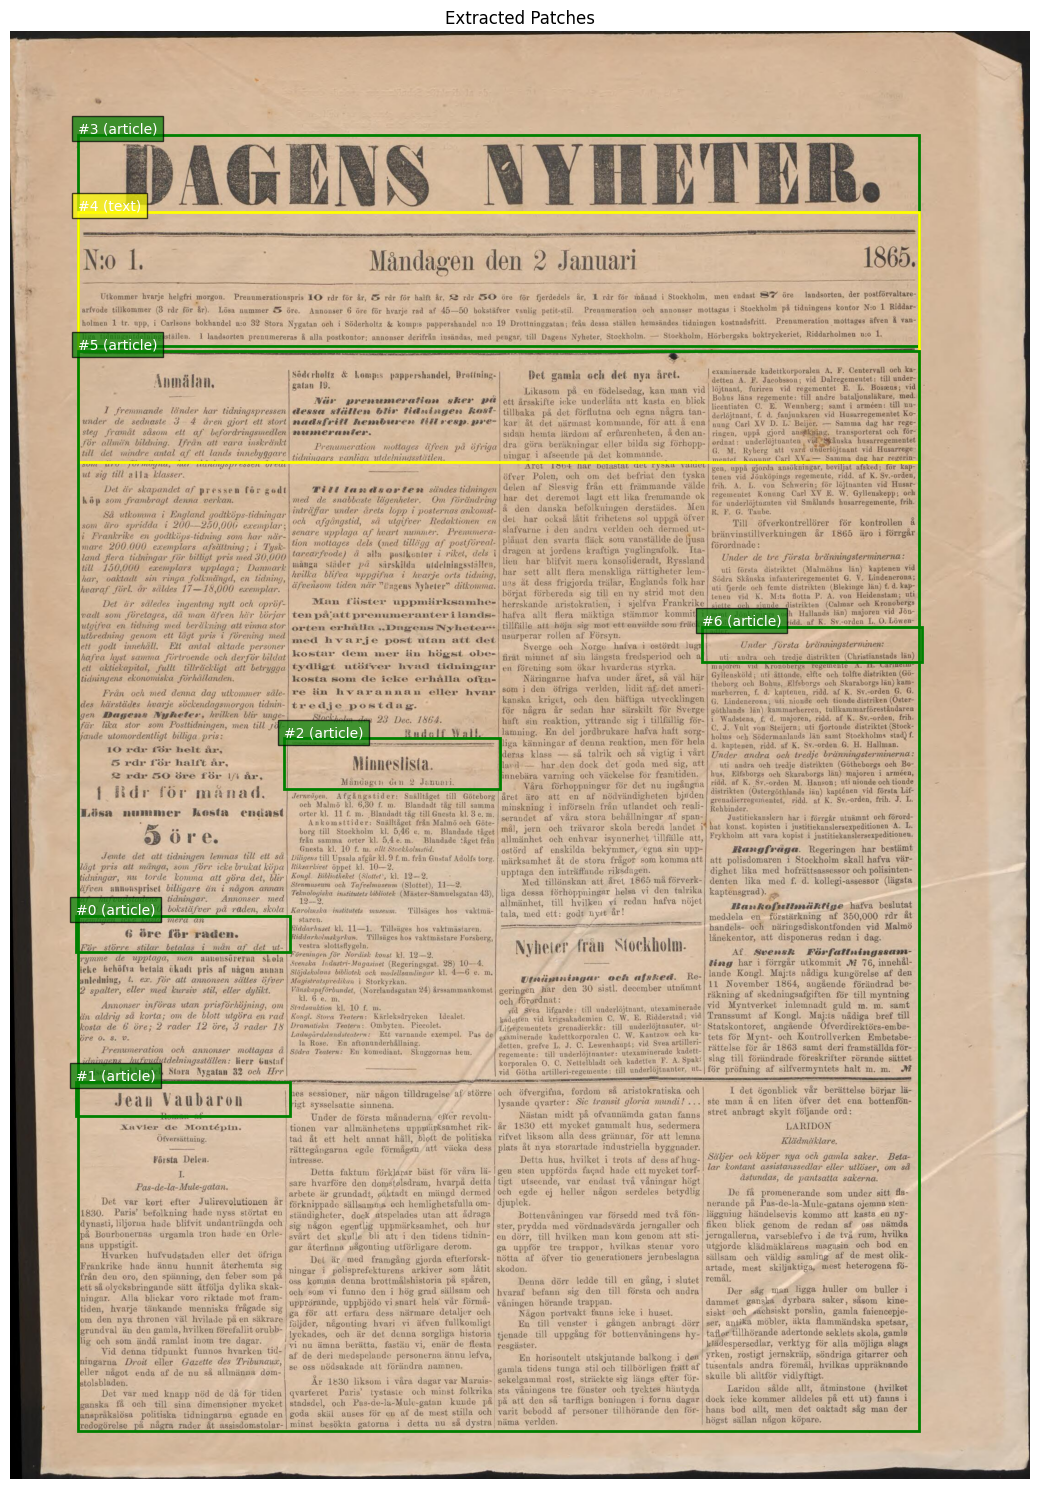

In [45]:
# Load JSON data
with open('../results/bib13991099_18650102_0_1_0001_2218x3150_detected.json', 'r') as f:
    json_data = json.load(f)

# Process the newspaper page with overlap resolution and the fixed function
patches = process_newspaper_page_with_overlap_resolution(
    image_path='../data/bib13991099_18650102_0_1_0001_2218x3150.jpg',
    json_data=json_data,
    output_dir='extracted_patches',
    confidence_threshold=0.6,
    min_height=100,
    min_width=100,
    padding=5,  # Reduced padding to minimize overlap
    visualize=True
)